# NIH Grant & Funding Data Dashboard  

## *What do health science researchers want to know about the Grants & Funding from National Institutes of Health?*

Insert NIH Graphs Here

Begun as a one-room Laboratory of Hygiene in 1887, the National Institutes of Health (NIH) today is one of the world’s foremost medical research centers. It is also the largest public funder of biomedical research in the world, investing more than $32 billion a year to enhance life, and reduce illness and disability. Yet, the devil is in the details. The painstaking process of grant application and review has long been questioned by many researchers that spent more time writing up proposals than doing actual research. With a blogpost on 'the inequality in NIH funding distribution' published last year by the NIH office, more questions regarding how the money was spent were brought up by the researchers. In this project, we attempt to answer some of their key questions through data analysis and visualization using a web-based dashboard. 

Git: https://github.com/linnilinnil/NIH-Fundings-Dashboard/tree/master 

Insert screenshots of Comments Here 

## Overview 

Our analysis contains four aspects: 

INSERT POWERPOINT HERE

Some of the key achievements and takeaways of our projects include: 

INSERT POWERPOINT HERE

The technical components involved are: 
- SQL Database interaction
- Complex visualization with Plotly
- Web-based application with flask + Dash
- Data collection and cleaning (some through API request)

【INSERT FLOWCHART]

We would be using the following packages and libraries: 

In [12]:
# importing dependencies 
import os
import glob
import regex as re
import json
from urllib.request import urlopen
import requests
import time
from geopy import Nominatim
import sqlite3
# dash
import dash
from dash import Dash, dcc, html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output, State

# plotting and df
import plotly
print(plotly.__version__)
import plotly.graph_objs as go
import plotly.express as px
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt

import io
import PIL
r = np.random.RandomState(42)


5.13.0


## Data cleaning (TL;DR)

We first take a look at this data:  
NIH Awards: by project names, prpoject number (Activity code included) Location, Organization, admin IC, funding mechanisms, direct costs, and indirect costs per fiscal year and project number 
https://report.nih.gov/award/index.cfm?ot=&fy=2023&state=&ic=&fm=&orgid=&distr=&rfa=&om=n&pid=#tab5 
 

To create a map visualization, we would be needing the relevant FIPS code for states and counties.  

We import a city FIPS table for geospatial data display. The following dataset maps county (all upper cases) to their FIPs, because county FIPS are needed to visualize the county map in plotly. 

In [9]:
cfips = pd.read_csv("county-fips.csv")
cfips["full_name"] = (cfips["county_name"]+" "+cfips["state_name"]).str.upper()
fip_dict = dict(zip(list(cfips["full_name"]),list(cfips["fips"])))
list(fip_dict.items())[1:5]


[('BALDWIN COUNTY ALABAMA', 1003),
 ('BARBOUR COUNTY ALABAMA', 1005),
 ('BIBB COUNTY ALABAMA', 1007),
 ('BLOUNT COUNTY ALABAMA', 1009)]

And the following table is capable of mapping city to their respective county. 

In [22]:
# just downloaded the county and city fips code from us census data and mapped
city = pd.read_csv("uscities.csv")
city.city = city.city.str.upper()
city.county_name = city.county_name.str.upper()
city.state_name = city.state_name.str.upper()
city = city.dropna()
# store data in database data.db table name "decade"
try:
    conn = sqlite3.connect("data.db")
    city.to_sql("city",conn,index=False)
    conn.close()
except:
    print("The city table already existed.")



The city table already existed.


However, since this table does not contain information on all cities, we make further use of the geolocator module to fill in the missing information. 

In [12]:
# retrieving location: longitude and latitude based on city and state

geolocator = Nominatim(user_agent="app")


The following would be a dict to map state full name to state two-letter code. Plotly has an option to display state map by state code (two letters). 

In [13]:
anym = pd.read_csv("acronynm.csv")
c_dict = dict(zip(list(anym.state.str.upper()),list(anym.code)))

Now we fill in some additional information to make mapping geo codes and future visualization easier:
- MONTH: derive from award notice date
- YEAR: derive from award notice data also
- CITY, STATE: convert to upper
- FULL_LOC: combine city and state, make searching with geo_locator easier
- CODE: state code

In [ ]:

data = pd.DataFrame()
path = "/Users/linlin/Desktop/2023/16b/dash/awardsbyloc"
xls_list = os.listdir(path)
xlsx = glob.glob(os.path.join(path, "*.xls"))
for x in xlsx:
    if '.DS_Store' not in x:
        print(x)
        df = pd.read_excel(x)
        df.columns = [s.upper() for s in list(df.columns)]
        df["MONTH"] = pd.to_datetime(df["AWARD NOTICE DATE"]).dt.month
        df["YEAR"] = pd.to_datetime(df["AWARD NOTICE DATE"]).dt.year
        df["CITY"] = df["CITY"].str.upper()
        df["STATE OR COUNTRY NAME"] = df["STATE OR COUNTRY NAME"].str.upper()
        df["FULL_LOC"] = df["CITY"] + " " + df["STATE OR COUNTRY NAME"]
        df['CODE'] = df["STATE OR COUNTRY NAME"].map(c_dict)
        
        if len(data) == 0:
            data = df
        else:
            data = pd.concat([data, df],    # Combine vertically
                            ignore_index = False,
                            sort = False)

        

We retain only the relevant columns in the dataset.

In [27]:
data = data[['ORGANIZATION NAME', 'ORGANIZATION ID (IPF)', 'PROJECT NUMBER',
       'FUNDING MECHANISM', 'PI NAME', 'PI PERSON ID',
       'PROJECT TITLE', 'DIRECT COST', 'INDIRECT COST', 'FUNDING',
       'CITY', 'STATE OR COUNTRY NAME',
       'INSTITUTION TYPE', 'AWARD NOTICE DATE','MONTH', 'YEAR',
       'FULL_LOC', 'CODE']]
data = data[data.YEAR.notna()]
data.shape

(611898, 18)

The different funding mechanisms and institution types of NIH Project and Funding Grants are: 

In [17]:
data['INSTITUTION TYPE'] = data['INSTITUTION TYPE'].fillna('None')

In [18]:
data['INSTITUTION TYPE'].unique()

array(['None', 'Research Institutes', 'Domestic Higher Education',
       'Independent Hospitals'], dtype=object)

In [19]:
data['FUNDING MECHANISM'].unique()

array(['RPGs - SBIR/STTR', 'RPGs - Non SBIR/STTR',
       'Other Research-Related', 'Training - Individual',
       'Training - Institutional', 'Research Centers', 'Other',
       'Construction'], dtype=object)

INSERT EXPLANATION TABLE

Since we have a huge amount of data —— over 600k entries, it would be wise to store and query the data using databases. 

In [20]:
# store data in database data.db table name "decade"

conn = sqlite3.connect("data.db")
cur = conn.cursor()
cur.execute("DROP TABLE IF EXISTS decade")
conn.commit()
data.to_sql("decade",conn,index=False)

611898

Now, it's time to write a query function to select data by fiscal year, funding mechanism, and insitution type. Additionally, we would want to map the data to corresponding geocodes, and fill in anything that is missing with the geolocator module.  (The functions are saved in separate python files as required.)

Let's write a small helper function to print all tables in a given database, too.

In [28]:
def print_table(db = 'data.db'):
    conn = sqlite3.connect(db)
    alltbl = """SELECT name FROM sqlite_master  
    WHERE type='table';"""
    cur = conn.cursor()
    print(cur.execute(alltbl).fetchall())
    conn.close()
print_table()

[('decade',), ('city',)]


In [29]:

FME = ['RPGs - SBIR/STTR',
 'RPGs - Non SBIR/STTR',
 'Other Research-Related',
 'Training - Individual',
 'Training - Institutional',
 'Research Centers',
 'Other',
 'Construction']
INST = ['None',
 'Research Institutes',
 'Domestic Higher Education',
 'Independent Hospitals']
col = ['ORGANIZATION NAME',
 'ORGANIZATION ID (IPF)',
 'PROJECT NUMBER',
 'FUNDING MECHANISM',
 'PI NAME',
 'PI PERSON ID',
 'PROJECT TITLE',
 'DIRECT COST',
 'INDIRECT COST',
 'FUNDING',
 'CITY',
 'STATE OR COUNTRY NAME',
 'INSTITUTION TYPE',
 'AWARD NOTICE DATE',
 'MONTH',
 'YEAR',
 'FULL_LOC',
 'CODE']
def map_que(year=list(np.arange(2012,2022)),month=list(np.arange(1,12)),
            fme = FME,
            inst = INST):
        cmd = '''
        SELECT D.*,C.COUNTY_FIPS,C.COUNTY_NAME,C.LAT,C.LNG
        FROM 
                (SELECT LNG,LAT,COUNTY_NAME,CITY,COUNTY_FIPS,STATE_ID
                FROM city) AS C
        LEFT JOIN decade as D
        ON D.CITY = C.CITY
        WHERE D.YEAR IN ''' + str(tuple(year))\
        + ''' AND MONTH IN ''' + str(tuple(month))\
        + ''' AND D.[FUNDING MECHANISM] IN ''' + str(tuple(fme))\
        + ''' AND D.[INSTITUTION TYPE] IN ''' + str(tuple(inst))#+'''LIMIT 1'''
        conn = sqlite3.connect("data.db")
        cursor = conn.cursor()

        cursor.execute(cmd)
        df = pd.DataFrame(cursor.fetchall(),columns=col+["COUNTY_FIPS","COUNTY_NAME","LAT","LNG"])
        print(df.head(n=1))
        conn.close()
        return df
df = map_que() 



  ORGANIZATION NAME  ORGANIZATION ID (IPF)   PROJECT NUMBER FUNDING MECHANISM  \
0       5 POINT APP             10052988.0  1R43CA261446-01  RPGs - SBIR/STTR   

         PI NAME  PI PERSON ID  \
0  BECK, SUSAN L     6170838.0   

                                       PROJECT TITLE  DIRECT COST  \
0  A New Multi-functional and Connected Mobile Ap...          NaN   

   INDIRECT COST  FUNDING  ... INSTITUTION TYPE    AWARD NOTICE DATE MONTH  \
0            NaN   397367  ...             None  2021-09-16 00:00:00   9.0   

     YEAR           FULL_LOC  CODE COUNTY_FIPS COUNTY_NAME      LAT      LNG  
0  2021.0  NEW YORK NEW YORK    NY       36081      QUEENS  40.6943 -73.9249  

[1 rows x 22 columns]


The query took quite long to run on my MAC, some where between 1 to 3 minutes, so ideally we might want to query all of them when we open the web app and subset for different filters.

Next, we fill in the missing locations with the following function: 

In [30]:
def geo_encode(dat,fip_dict):
    proj = dat.copy()
    #BECAUSE THERE ARE DUPLICATED VALUES AND USUALLY THE FIRST OCCURENCES ARE RIGHT
    locs = list(dat.FULL_LOC)
    lngs =  list(dat.LNG)
    lats = list(dat.LAT)
    fips = list(dat.COUNTY_FIPS)
    countys = list(dat.COUNTY_NAME)
    
    lon_dict = dict(zip(list(locs),list(lngs)))
    lat_dict = dict(zip(list(locs),list(lats)))
    ct_dict = dict(zip(list(locs),list(countys)))
    fip_dict = dict(zip(list(locs),list(fips)))
    notfound = (proj[proj["LAT"].isna()]["FULL_LOC"]).unique()
    #print(notfound)

    geo = [geolocator.geocode(i) for i in notfound] 
    lat = [i.latitude if i is not None else np.nan for i in geo]
    lon = [i.longitude if i is not None else np.nan for i in geo]
    county = [i.address.upper().split(", ")[1] if i is not None else np.nan for i in geo]
    fip = [fip_dict.get(i.address.upper().split(", ")[1] + " " +i.address.upper().split(", ")[2]) \
           if i is not None else np.nan 
           for i in geo]
    
    notfoundl = list(notfound)
    lat_add = dict(zip(notfoundl,lat))
    lon_add = dict(zip(notfoundl,lon))
    ct_add = dict(zip(notfoundl,county))
    fip_add = dict(zip(notfoundl,fip))

    ct_dict.update(ct_add)
    fip_dict.update(fip_add)
    lat_dict.update(lat_add)
    lon_dict.update(lon_add)
    
    proj["COUNTY"] = proj["FULL_LOC"].map(ct_dict)
    proj["FIPS"] = proj["FULL_LOC"].map(fip_dict)
    proj["LNG"] = proj["FULL_LOC"].map(lon_dict)
    proj["LAT"] = proj["FULL_LOC"].map(lat_dict)
    return proj 



As you would see, the geolocator runs on API request so it is going to take a long time as well ( which mde me resave the whole datatable).

In [31]:

proj = geo_encode(df,fip_dict)

In [33]:
# Let's resave the data, store data in database data.db table name "decade" 

conn = sqlite3.connect("data.db")
cur = conn.cursor()
cur.execute("DROP TABLE IF EXISTS decade")
conn.commit()
proj.to_sql("decade",conn,index=False)
conn.close()

## Geospatial Analysis  

Now, let's plot a state choropleth map to visualize the funding distributions. For the sake of time, I will just keep working with the dataframe in the workspace. The choropleth map would be colored by one of the following metrics:
- Total fundings/number of organizations 
- Total fundings/number of projects 
- Total fundings/number of PI IDs 

//another way of doing this is to further normalize, if we were to look at the data irregardless of the funding/institute tyoe, we do a basket norm

In [34]:
proj.columns

Index(['ORGANIZATION NAME', 'ORGANIZATION ID (IPF)', 'PROJECT NUMBER',
       'FUNDING MECHANISM', 'PI NAME', 'PI PERSON ID', 'PROJECT TITLE',
       'DIRECT COST', 'INDIRECT COST', 'FUNDING', 'CITY',
       'STATE OR COUNTRY NAME', 'INSTITUTION TYPE', 'AWARD NOTICE DATE',
       'MONTH', 'YEAR', 'FULL_LOC', 'CODE', 'COUNTY_FIPS', 'COUNTY_NAME',
       'LAT', 'LNG', 'COUNTY', 'FIPS'],
      dtype='object')

In [116]:
# Average funding per organization
fund_org_avg = proj.groupby(
    ['CODE','YEAR','FUNDING MECHANISM','INSTITUTION TYPE','ORGANIZATION NAME']
    )['FUNDING'].agg('mean') 
fund_org_avg = fund_org_avg.reset_index(0).reset_index(0).reset_index(0).reset_index(0).reset_index(0)
fund_org_avg = proj.groupby(
    ['CODE','YEAR','FUNDING MECHANISM','INSTITUTION TYPE']
    )['FUNDING'].agg('mean') 
fund_org_avg = fund_org_avg.reset_index(0).reset_index(0).reset_index(0).reset_index(0)
#for demo
fund_org_avg.to_csv('fund_org_avg.csv')
fund_org_avg.head()


,INSTITUTION TYPE,FUNDING MECHANISM,YEAR,CODE,FUNDING
0,Domestic Higher Education,Other Research-Related,2012.0,AK,2.869343e+05
1,Domestic Higher Education,RPGs - Non SBIR/STTR,2012.0,AK,3.684612e+05
2,None,RPGs - Non SBIR/STTR,2012.0,AK,3.097755e+05
3,Domestic Higher Education,Research Centers,2012.0,AK,2.311864e+06
4,Domestic Higher Education,Other Research-Related,2013.0,AK,2.007843e+05


In [118]:
# Average funding per pi ~ to a team/lab
fund_pi_avg = proj.groupby(
    ['CODE','YEAR','FUNDING MECHANISM','INSTITUTION TYPE','PI PERSON ID']
    )['FUNDING'].agg('mean') 
fund_pi_avg = fund_pi_avg.reset_index(0).reset_index(0).reset_index(0).reset_index(0).reset_index(0)
fund_pi_avg = proj.groupby(
    ['CODE','YEAR','FUNDING MECHANISM','INSTITUTION TYPE']
    )['FUNDING'].agg('mean') 
fund_pi_avg = fund_pi_avg.reset_index(0).reset_index(0).reset_index(0).reset_index(0)

fund_pi_avg.to_csv('fund_pi_avg.csv')
fund_pi_avg.head()

,INSTITUTION TYPE,FUNDING MECHANISM,YEAR,CODE,FUNDING
0,Domestic Higher Education,Other Research-Related,2012.0,AK,2.869343e+05
1,Domestic Higher Education,RPGs - Non SBIR/STTR,2012.0,AK,3.684612e+05
2,None,RPGs - Non SBIR/STTR,2012.0,AK,3.097755e+05
3,Domestic Higher Education,Research Centers,2012.0,AK,2.311864e+06
4,Domestic Higher Education,Other Research-Related,2013.0,AK,2.007843e+05


In [117]:
# average funding per project
fund_proj_avg = proj.groupby(
    ['CODE','YEAR','FUNDING MECHANISM','INSTITUTION TYPE']
    )['FUNDING'].agg('mean')
fund_proj_avg = fund_proj_avg.reset_index(0).reset_index(0).reset_index(0).reset_index(0)

fund_proj_avg.to_csv('fund_proj_avg.csv')
fund_proj_avg.head()

,INSTITUTION TYPE,FUNDING MECHANISM,YEAR,CODE,FUNDING
0,Domestic Higher Education,Other Research-Related,2012.0,AK,2.869343e+05
1,Domestic Higher Education,RPGs - Non SBIR/STTR,2012.0,AK,3.684612e+05
2,None,RPGs - Non SBIR/STTR,2012.0,AK,3.097755e+05
3,Domestic Higher Education,Research Centers,2012.0,AK,2.311864e+06
4,Domestic Higher Education,Other Research-Related,2013.0,AK,2.007843e+05


The following is an example animated graph of the average funding per project by state: 

In [27]:
by_year = fund_proj_avg.groupby(
    ['CODE','YEAR']
    )['FUNDING'].agg('mean').reset_index(0).reset_index(0)
fig = px.choropleth(by_year,locations="CODE", animation_frame = 'YEAR',locationmode="USA-states", color="FUNDING", scope="usa",range_color=(0, 2*10e5),width=800,height=500)
fig.show()



## Research Trend / Demand 

In this part, we would be examining a funding history of different categories generated by RCDC —— computerized process the NIH uses to categorize and report the amount it funded in each of the more than 280 reported categories of disease, condition, or research area. 

The table contains estaimted fundings for 2022,2023, historical fundings from 2008 to 2021, and the disease prevalence/death counts totaled in 2019. In 2008, 2009, extra funding and grants were allocated to NIH projects as a result of the American Recovery and Reinvestment Act, a.k.a. Obama Stimulus. We have combined them with the 2008 and 2009 funding columns. 



In [28]:
rcdc = pd.read_excel("RCDCFundingSummary_03072023.xlsx",)
rcdc.columns = rcdc.loc[1,:]
rcdc = rcdc.loc[2:310,:]


The following function is written to clean the RCDC summary data. 

In [35]:
def RCDC_clean(rcdc):
    
    selected = rcdc.copy()
    #- indicates no death from this category
    selected['2019 US Mortality 19'] \
        = selected['2019 US Mortality 19'].apply(lambda x:str(x).replace('-','0'))
    #+ indicates the category did not exist in that specific year. 
    # encode to a numeric indicator
    selected = selected.applymap(lambda x:str(x).replace('+','-1'))
    #get rid of the dollar signs so as to convert to numeric
    selected = selected.applymap(lambda x:str(x).replace('$',''))

    #combining ARRA
    selected[2009]=selected[2009].astype(float) + selected['2009 ARRA'].astype(float)
    selected[2010]=selected[2010].astype(float) + selected['2010 ARRA'].astype(float)
    selected.drop(['2009 ARRA','2010 ARRA'],axis=1,inplace=True)

    #number of years the category has existed
    selected['exist'] = selected.apply((lambda row: sum([1 if (row[x] != '-1') else 0 for x in list(selected.columns)[1:-3]])),axis = 1)
    #average fundings over the year
    selected['avg'] = selected.apply((lambda row: np.mean([int(row[x]) if (row[x] != '-1') else 0 for x in list(selected.columns)[1:-3]])),axis = 1)
    #estimated increase from 2022 to 2023
    selected['estimate'] = selected['2023 Estimated'].astype(float) - selected['2022 Estimated'].astype(float) 
    #type conversion
    selected['2019 US Mortality 19'] = selected['2019 US Mortality 19'].astype('float')
    #percentage of increase
    selected["pct2023"] = selected.loc[:,['2022 Estimated','2023 Estimated']].astype(float).pct_change(axis=1)['2023 Estimated'].multiply(100)
    #sorting
    selected =selected.sort_values('2019 US Mortality 19')
    print(selected.head(n=1))
    #We divide the categories into lethal conditions, and non lethal
    fatal = selected[selected['2019 US Mortality 19'] > 0]
    nonfatal = selected[selected['2019 US Mortality 19'] == 0]
    return fatal, nonfatal




In [36]:
fatal, nonfatal = RCDC_clean(rcdc)

1 Research/Disease Areas \n (Dollars in millions and rounded) 2008  2009  \
2                     Acquired Cognitive Impairment             -1  -2.0   

1  2010 2011 2012 2013 2014 2015  2016  ...  2020  2021 2022 Estimated  \
2  -2.0   -1   -1   -1   -1  798  1132  ...  2897  3259           3555   

1 2023 Estimated 2019 US Mortality 19 2019 US Prevalence SE 19 exist     avg  \
2           3354                  0.0                        -    10  1309.5   

1 estimate   pct2023  
2   -201.0 -5.654008  

[1 rows x 23 columns]


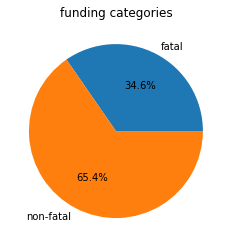

In [57]:
plt.pie([len(fatal),len(nonfatal)],labels=['fatal','non-fatal'],autopct='%1.1f%%')
plt.title('funding categories')
plt.show()


Our first attempt in investigating the data is to figure out whether there is any association among fatality/prevalence, category existed time, average fundings in the past, and the estimated increase in funding. Since quite a lot of variables are involved, without doing any regression analysis, an (perhaps) intuitive way to show the association is through the parallele category plots. 

But before that, we should divide the funding and mortality counts into different bins based on their distributions. 

In [59]:
px.histogram(fatal['2019 US Mortality 19'],nbins=500)

In [60]:

mort_bins = pd.IntervalIndex.from_tuples([(0, 50*10e2),(50*10e2, 99*10e2), (99*10e2, 100*10e2),
                                        (100*10e2, 150*10e2),
                                        (150*10e2, 200*10e2),
                                        (200*10e2, 250*10e2),
                                        (250*10e2, 300*10e2),
                                        (300*10e2, 350*10e2),
                                        (350*10e2, 400*10e2),
                                        (400*10e2, 1*10e6),
                                        (10e6, 2*10e6)])
mort_dict = dict(zip([str(i) for i in list(mort_bins)],['<5k','5-10k','10-100k',
                                 '100-150k',
                                 '150-200k',
                                 '200-250k',
                                 '250-300k',
                                 '300-350k',
                                 '350-400k',
                                 '400k - 1M',
                                 '> 1M']))

In [62]:
px.histogram(fatal['pct2023'])

In [63]:
pct_bins = pd.IntervalIndex.from_tuples([(-300,-20),(-20, -10),(-10,-5), (-5,0),
                                        (0,5),
                                        (5,10),
                                        (10,15),
                                        (15,20),
                                        (20,300)])
pct_dict = dict(zip([str(i) for i in list(pct_bins)],['< -20','-20 ~ -10','-10 ~ -5', '-5 ~ 0',
                                                       '0 ~ 5',
                                                       '5 ~ 10',
                                                       '10 ~ 15',
                                                       '15 ~ 20',
                                                       '> 20']))
fatal['est_bin'] = pd.cut(fatal['estimate'], pct_bins).astype(str)
fatal['mort_bin'] = pd.cut(fatal['2019 US Mortality 19'], mort_bins).astype(str)
fatal['mort_str'] = fatal['mort_bin'].astype(str).map(mort_dict)
fatal['est_str'] = fatal['est_bin'].astype(str).map(pct_dict)

In [67]:
#df = px.data.tips()
fig = px.parallel_categories(fatal, dimensions=['exist','est_str','mort_str'],
                color="exist", color_continuous_scale="Viridis",
                labels={'exist':'Category existed time (yr)',
                        'est_str':'Estimated pct. change',
                        'mort_str':'Mortality rate (raw ct.)'},
                height = 500,
                width = 900
                )
dimensions=['exist','est_str','mort_bin']
fig.update_traces(dimensions=[{"categoryorder": "category descending"} for _ in dimensions])
plt.tight_layout()
fig.show()

<Figure size 432x288 with 0 Axes>

Let's also take a look at how the top-funded categories have changed in the past decade. 

In [73]:
fatal10 = fatal.sort_values('2019 US Mortality 19').iloc[-10:,]
sem = pd.melt(fatal10, id_vars=['Research/Disease Areas \n (Dollars in millions and rounded)'], 
        value_vars=fatal.columns[1:17],
        var_name='year', value_name='value')
sem = sem.rename(columns={'2022 Estimated': '2022','2023 Estimated': '2023'})
sem['value'] = sem['value'].astype(int)
fig = px.bar(sem, x='Research/Disease Areas \n (Dollars in millions and rounded)', 
             y="value", color='Research/Disease Areas \n (Dollars in millions and rounded)',
             title='Top 10 funded fatal diseases',
  animation_frame="year",width = 1000,height = 600,range_y=[0,8000])

fig.show()

In [80]:
nfatal10 = nonfatal.sort_values('2019 US Mortality 19').iloc[-10:,]
sem = pd.melt(nfatal10, id_vars=['Research/Disease Areas \n (Dollars in millions and rounded)'], 
        value_vars=fatal.columns[1:17],
        var_name='year', value_name='value')
sem = sem.rename(columns={'2022 Estimated': '2022','2023 Estimated': '2023'})
sem['value'] = sem['value'].astype(int)
fig = px.bar(sem, x='Research/Disease Areas \n (Dollars in millions and rounded)', 
             y="value", color='Research/Disease Areas \n (Dollars in millions and rounded)',
             title='Top 10 funded nonfatal conditions',
  animation_frame="year",width = 1000,height = 600,range_y=[0,800])

fig.show()

We would be adding more [interactive visualizations[(https://dash.plotly.com/interactive-graphing)] for this part later in the dash app. Mainly, we would be displaying the time-series data for each category based on user selection. Once user hovers over a category, we would display the change in the funding for that category over the past decade on the side:


In [110]:
cancer = fatal[fatal['Research/Disease Areas \n (Dollars in millions and rounded)'] == 'Cancer ']
cancer.rename(columns={'2022 Estimated': '2022','2023 Estimated':'2023'})

melted = pd.melt(cancer, id_vars=['Research/Disease Areas \n (Dollars in millions and rounded)'], 
        value_vars=fatal.columns[1:17],
        var_name='year', value_name='value')
melted['value'] = melted['value'].astype(int)
fig = px.line(melted,x='year',y='value',title="change in cancer research funding, Million USD")
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1
    )
)

## Dashboard component - Example: Map

[Dash](https://plotly.com/dash/) is a built upon the plotly library and well-integrated with flask for web app deplotment. From their product description: "Dash apps give a point-&-click interface to models written in Python, vastly expanding the notion of what's possible in a traditional 'dashboard.'". Below is a demostration of how to transfer the choropleth maps we've plotted above to a web-based interactive dashboard.  

To get started, create a python file name **app.py**, where you would write the html components
and callbacks (mainly for updating graphs based on user inputs); also make a new folder under the same directory name **assests**, where you will store your images and CSS (in **style.css**)

In **app.py**, the code would look something like this: 

```python
# Run this app with `python app.py` and
# visit http://127.0.0.1:8050/ in your web browser.

from dash import Dash, html, dcc
import plotly.express as px
import pandas as pd

# Initialize app
app = Dash(__name__)

# Define, read, or pull your data
df = ...

fig = px... # Define the graph you want to put on the dashboard

app.layout = html.Div(children=[
    html.H1(children='Hello Dash'),

    html.Div(children='''
        Dash: A web application framework for your df.
    '''),

    dcc.Graph(
        id='example-graph',
        figure=fig
    )
]) ## Define HTML layout

## Just like flask
if __name__ == '__main__':
    app.run_server(debug=True) # Setting this to true will allow browser                     auto-refresh on code change
```

If you want to read more about how this becomes what you will see in the borwser, you could read more [here](https://dash.plotly.com/layout).

```python
#importing the necessary components
import dash
from dash import html, dcc
from dash.dependencies import Input, Output, State
import dash_daq as daq
import dash_bootstrap_components as dbc
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px

#host files on github
path = 'https://raw.githubusercontent.com/linnilinnil/NIH-Fundings-Dashboard/main/'

#read in file, for demo purpose they all come from pre-saved csv.
fund_org = pd.read_csv(path + "fund_org_avg.csv")
fund_pi = pd.read_csv(path + "fund_pi_avg.csv")
fund_proj = pd.read_csv(path + "fund_proj_avg.csv")



#------------------------------------------------------ APP ------------------------------------------------------ 

app = dash.Dash(__name__)

server = app.server

app.layout = html.Div([

    html.Div([
        html.H1(children='NIH FUNDING\n& GRANTS DATA'),
        html.Label(['We are interested in investigating the distributions and usage of NIH Research Project Grants & Fundings. We based our data analysis and visualization on some of the key questions asked by researchers regarding the NIH funding & grants data in this ',
                    html.A('post.',href='https://nexus.od.nih.gov/all/2022/01/18/inequalities-in-the-distribution-of-national-institutes-of-health-research-project-grant-funding/')], 
                    style={'color':'rgb(33 36 35)'})
    ], className='side_bar'),
])

if __name__ == '__main__':
    app.run_server(debug=True)
```

Which will show you something like this: 

[INSERT BLANK PAGE HERE]

Then, we move on to add the choropleth to the page, and a slider option to choose which year's data to display. 

To write a slider, we first define it before the app.layout, and create another html.div to store it. 

```python
#define a slider
year_slider = daq.Slider(
        id = 'year_slider',
        handleLabel={"showCurrentValue": True,"label": "Year"},
        marks = {str(i):str(i) for i in years},
        min = min(years),
        max = max(years),
        size=450, 
        color='0c4db4'
    )
#layout >>
    #htmlDiv: for title and descripton
    #htmlDiv: for year slider
html.Div([year_slider], 
        style={'margin-left': '15%', 'position':'relative', 'top':'100px'}),

```

[INSERT SLIDER IMAGE]

We now move on to the graph component, which would be hosted under dcc.Graph:

```python
##after the slider div
 dcc.Graph(id='map', 
              figure = dict(
              ),
              style={'position':'relative', 'top':'200px'})
```

Don't worry about how empty it looks at the moment, we would add a [**callback**](https://dash.plotly.com/basic-callbacks) function to update the graph content based on the slider selection. Callbacks are functions that are automatically called by Dash whenever an input component's property changes, in order to update some property in another component (the output).

(To include other existing user selected components as inputs, that might not necessarily be changed along the specified input, use [State]）

In this callback, we return a plotly figure (which consists of the data and layout components) based on the user-selected year and the dataframes that already exsit in the environment. 

```python

@app.callback(
    Output(component_id='map', component_property='figure'),
    Input(component_id='year_slider', component_property='value')
)
def update_map(yr):
    by_year = fund_proj[fund_proj['YEAR']==int(yr)]
    by_year = by_year.groupby(
    ['CODE']
    )['FUNDING'].agg('mean').reset_index(0)

    fig = px.choropleth(by_year,color='FUNDING',
                        locations="CODE", 
                        locationmode="USA-states", 
                        scope="usa",
                        range_color=(0, 2*10e5),
                        width=800,
                        height=500)
 
    return fig
```

## Final Dashboard 

Because there are quite a lot of components on this dashboard, I wouldn't go through the nitty-gritty of integrating every single one of them. Instead, here is a visualization of the dashboard structure: 

[INSERT DASHBORD STRUCTURE HERE]

## Discussion

### Risk 

### Impact

### Next step